In [13]:
from __future__ import division, print_function
%matplotlib inline
from utils import *
from keras.layers.merge import dot, add, concatenate
from pandas_summary import DataFrameSummary
import seaborn as sns

Using TensorFlow backend.


The goal is to predict the next order basket (list of products) for each user in the test set, given info about its prior orders.

# Set up data

Read data

In [14]:
order_products_train_df = pd.read_csv("data/order_products__train.csv")
order_products_prior_df = pd.read_csv("data/order_products__prior.csv")
orders_df = pd.read_csv("data/orders.csv")
products_df = pd.read_csv("data/products.csv")
aisles_df = pd.read_csv("data/aisles.csv")
departments_df = pd.read_csv("data/departments.csv")

Take a peak at the data

In [15]:
orders_df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [16]:
order_products_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [17]:
order_products_train_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [18]:
products_df.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


Collect order and product info for each user in the training set and then merge into a data frame df

In [20]:
df_train = orders_df.merge(order_products_train_df, how = 'inner', on = 'order_id')
df_train = df_train.merge(products_df, how = 'inner', on = 'product_id')
df_train.sort_values(['user_id', 'order_number'], axis=0, inplace=True)

In [21]:
df_prior = orders_df.merge(order_products_prior_df, how = 'inner', on = 'order_id')
df_prior = df_prior.merge(products_df, how = 'inner', on = 'product_id')
df_prior.sort_values(['user_id', 'order_number'], axis=0, inplace=True)

In [22]:
df = pd.concat([df_prior, df_train])

In [23]:
sample=int(1e5)
df = df.iloc[:sample]

In [24]:
#fillna
df.fillna(0,axis=0, inplace=True)
df.drop('eval_set', axis=1, inplace = True)
df.reset_index(drop = True, inplace = True)
del df_train, df_prior

In [25]:
df.head()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,2539329,1,1,2,8,0.0,196,1,0,Soda,77,7
1,2539329,1,1,2,8,0.0,14084,2,0,Organic Unsweetened Vanilla Almond Milk,91,16
2,2539329,1,1,2,8,0.0,12427,3,0,Original Beef Jerky,23,19
3,2539329,1,1,2,8,0.0,26088,4,0,Aged White Cheddar Popcorn,23,19
4,2539329,1,1,2,8,0.0,26405,5,0,XL Pick-A-Size Paper Towel Rolls,54,17


# Engineer new features

## product  list per user

Create new user features encoding order/product info

In [26]:
#separate orders according to their eval_set
prior = orders_df[orders_df["eval_set"]=='prior']
train = orders_df[orders_df["eval_set"]=='train']
test = orders_df[orders_df["eval_set"]=='test']

#get user_ids and the number of users in each eval_set
user_ids_total, n_users_total = prior['user_id'].unique(), prior['user_id'].nunique()
user_ids_train, n_users_train = train['user_id'].unique(), train['user_id'].nunique()
user_ids_test, n_users_test = test['user_id'].unique(), test['user_id'].nunique()

del prior
print("n_users_total = {}, n_users_train = {}, n_users_test = {}".format(n_users_total, n_users_train, n_users_test))

n_users_total = 206209, n_users_train = 131209, n_users_test = 75000


In [27]:
#group by user_id and order_number (this takes ~4 minutes to run locally on the entire data set).
X = df.groupby(['user_id', 'order_number'])['product_id'].apply(lambda x : list(x)).reset_index()
X.columns = ['user_id', 'order_number', 'product_list']

In [28]:
X.head()

,user_id,order_number,product_list
0,1,1,"[196, 14084, 12427, 26088, 26405]"
1,1,2,"[196, 12427, 26088, 10258, 13176, 13032]"
2,1,3,"[196, 12427, 10258, 25133, 30450]"
3,1,4,"[196, 12427, 26405, 10258, 25133]"
4,1,5,"[196, 12427, 10258, 13176, 25133, 10326, 17122..."


In [36]:
from keras.preprocessing.sequence import pad_sequences
sequences = np.array(X.product_list)
maxlen = X.product_list.map(len).max()

# pad sequence
padded = pad_sequences(sequences, padding='post', maxlen= maxlen)

In [38]:
padded.shape

(10059, 89)

In [30]:
#now group by user_id 
X_users =X.groupby('user_id')['product_list'].apply(lambda x : list(x)).reset_index()
X_users['num_orders_per_user'] = X_users.product_list.map(len)
X_users['ave_num_prods_per_order'] = X_users.product_list.map(lambda L: [len(x) for x in L]).map(np.mean).map(round)
X_users.set_index('user_id',inplace = True)

In [35]:
X_users.head()

,product_list,num_orders_per_user,ave_num_prods_per_order
user_id,,,
1,"[[196, 14084, 12427, 26088, 26405], [196, 1242...",10,6
2,"[[13176, 32792, 47766, 20574, 12000, 48110, 22...",14,14
3,"[[47766, 16797, 9387, 17668, 15143, 39190, 219...",12,7
4,"[[36606, 7350, 35469, 2707], [42329, 7160], [3...",5,4
5,"[[15349, 21413, 48775, 28289, 8518, 11777, 317...",4,9


In [39]:
X_users.shape

(667, 3)

## product rating per user

Create a new product 'rating' feature encoding the likelyhood of it being reordered by the user

In [287]:
#drop the first order for each user ('reodered' is meaningless in that case)
df2 = df[df['days_since_prior_order']!=0]

In [288]:
g=df2.groupby(['user_id','product_name','product_id'])

In [289]:
#create new data frame from df2
prod_ratings = df2.groupby(['user_id','product_name','product_id'])['reordered'].aggregate('sum').reset_index()

In [290]:
#reduce size of data
#prod_ratings = prod_ratings.iloc[0:100000]
prod_ratings.head()

,user_id,product_name,product_id,reordered
0,1,0% Greek Strained Yogurt,38928,0
1,1,Aged White Cheddar Popcorn,26088,1
2,1,Bag of Organic Bananas,13176,1
3,1,Bartlett Pears,41787,0
4,1,Cinnamon Toast Crunch,13032,2


Update product and user ids so that they are contiguous integers, which we want when using embeddings.

In [291]:
users = prod_ratings.user_id.unique()
prods = prod_ratings.product_id.unique()

userid2idx = {o:i for i,o in enumerate(users)}
prodid2idx = {o:i for i,o in enumerate(prods)}

prod_ratings.product_id = prod_ratings.product_id.apply(lambda x: prodid2idx[x])
prod_ratings.user_id = prod_ratings.user_id.apply(lambda x: userid2idx[x])

Apply StandardScaler (Subtract mean and divide by stdev) to the 'reordered' label 

In [292]:
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import StandardScaler

mapper = DataFrameMapper([('reordered', StandardScaler())], df_out=True)
prod_ratings.reordered = np.round(mapper.fit_transform(prod_ratings.copy()), 2)

/home/cyrfar/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
/home/cyrfar/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/cyrfar/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [293]:
prod_ratings.head()

,user_id,product_name,product_id,reordered
0,0,0% Greek Strained Yogurt,0,-0.42
1,0,Aged White Cheddar Popcorn,1,-0.14
2,0,Bag of Organic Bananas,2,-0.14
3,0,Bartlett Pears,3,-0.42
4,0,Cinnamon Toast Crunch,4,0.15


In [294]:
user_min, user_max, movie_min, movie_max = (prod_ratings.user_id.min(), 
    prod_ratings.user_id.max(), prod_ratings.product_id.min(), prod_ratings.product_id.max())
user_min, user_max, movie_min, movie_max

(0, 666, 0, 11863)

In [295]:
n_users = prod_ratings.user_id.nunique()
n_prods = prod_ratings.product_id.nunique()

n_users, n_prods

(667, 11864)

This is the number of latent factors in each embedding.

In [296]:
n_factors = 50

In [297]:
np.random.seed = 42

Randomly split into training and validation.

In [298]:
msk = np.random.rand(len(prod_ratings)) < 0.8
trn = prod_ratings[msk]
val = prod_ratings[~msk]

##  Simple Model using embeddings in Keras

In [299]:
def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(input_dim=n_in, output_dim=n_out, input_length=1, embeddings_regularizer=l2(reg))(inp)

In [300]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-3)
prod_in, p = embedding_input('prod_in', n_prods, n_factors, 1e-3)

In [301]:
def create_bias(inp, n_in):
    x = Embedding(input_dim=n_in, output_dim=1, input_length=1)(inp)
    return Flatten()(x)

In [302]:
ub = create_bias(user_in, n_users)
pb = create_bias(prod_in, n_prods)

In [308]:
x = dot([u, p], axes=2)
x = Flatten()(x)
x = add([x, ub])
x = add([x, pb])
model = Model([user_in, prod_in], x)
model.compile(Adam(0.001), loss='mse')

In [309]:
model.fit([trn.user_id, trn.product_id], trn.reordered, batch_size=64, epochs=6, 
          validation_data=([val.user_id, val.product_id], val.reordered))

Train on 31148 samples, validate on 7552 samples
Epoch 1/6
31148/31148 [==============================] - 9s - loss: 0.7896 - val_loss: 0.8201
Epoch 2/6
31148/31148 [==============================] - 8s - loss: 0.7840 - val_loss: 0.8207
Epoch 3/6
31148/31148 [==============================] - 8s - loss: 0.7780 - val_loss: 0.8219
Epoch 4/6
31148/31148 [==============================] - 8s - loss: 0.7723 - val_loss: 0.8234
Epoch 5/6
31148/31148 [==============================] - 8s - loss: 0.7669 - val_loss: 0.8250
Epoch 6/6
31148/31148 [==============================] - 8s - loss: 0.7620 - val_loss: 0.8268


In [310]:
model.optimizer.lr=0.01

In [311]:
model.fit([trn.user_id, trn.product_id], trn.reordered, batch_size=64, epochs=6, 
          validation_data=([val.user_id, val.product_id], val.reordered))

Train on 31148 samples, validate on 7552 samples
Epoch 1/6
31148/31148 [==============================] - 8s - loss: 0.7575 - val_loss: 0.8285
Epoch 2/6
31148/31148 [==============================] - 8s - loss: 0.7532 - val_loss: 0.8304
Epoch 3/6
31148/31148 [==============================] - 9s - loss: 0.7490 - val_loss: 0.8325
Epoch 4/6
31148/31148 [==============================] - 8s - loss: 0.7453 - val_loss: 0.8348
Epoch 5/6
31148/31148 [==============================] - 8s - loss: 0.7418 - val_loss: 0.8366
Epoch 6/6
31148/31148 [==============================] - 8s - loss: 0.7385 - val_loss: 0.8387


In [307]:
model.optimizer.lr=0.001

In [277]:
model.fit([trn.user_id, trn.product_id], trn.reordered, batch_size=64, epochs=10, 
          validation_data=([val.user_id, val.product_id], val.reordered))

Train on 30957 samples, validate on 7743 samples
Epoch 1/10
30957/30957 [==============================] - 8s - loss: 0.7734 - val_loss: 0.8861
Epoch 2/10
30957/30957 [==============================] - 8s - loss: 0.7669 - val_loss: 0.8860
Epoch 3/10
30957/30957 [==============================] - 8s - loss: 0.7612 - val_loss: 0.8864
Epoch 4/10
30957/30957 [==============================] - 8s - loss: 0.7560 - val_loss: 0.8870
Epoch 5/10
30957/30957 [==============================] - 8s - loss: 0.7512 - val_loss: 0.8876
Epoch 6/10
15424/30957 [=============>................] - ETA: 4s - loss: 0.6925

KeyboardInterrupt: 

In [202]:
model.fit([trn.user_id, trn.product_id], trn.reordered, batch_size=64, epochs=5, 
          validation_data=([val.user_id, val.product_id], val.reordered))

Train on 30870 samples, validate on 7830 samples
Epoch 1/5
30870/30870 [==============================] - 3s - loss: 0.7287 - val_loss: 0.9576
Epoch 2/5
30870/30870 [==============================] - 2s - loss: 0.7245 - val_loss: 0.9586
Epoch 3/5
30870/30870 [==============================] - 2s - loss: 0.7205 - val_loss: 0.9599
Epoch 4/5
30870/30870 [==============================] - 2s - loss: 0.7168 - val_loss: 0.9613
Epoch 5/5
30870/30870 [==============================] - 2s - loss: 0.7133 - val_loss: 0.9626


In [188]:
model.save_weights('models/simplemodel.h5')

In [189]:
model.load_weights('models/simplemodel.h5')

We can use the model to generate predictions by passing a pair of ints - a user id and a product id. For instance, this predicts that user #0 is likely to reorder product #15 (soda) and not likely to reorder product #12 (organic whole milk).

In [190]:
model.predict([np.array([0]), np.array([16])]), model.predict([np.array([0]), np.array([13])])

(array([[ 0.7034]], dtype=float32), array([[ 0.4901]], dtype=float32))

In [191]:
prod_ratings

,user_id,product_name,product_id,reordered
0,0,0% Greek Strained Yogurt,0,-0.42
1,0,Aged White Cheddar Popcorn,1,-0.14
2,0,Bag of Organic Bananas,2,-0.14
3,0,Bartlett Pears,3,-0.42
4,0,Cinnamon Toast Crunch,4,0.15
5,0,Creamy Almond Butter,5,-0.42
6,0,Honeycrisp Apples,6,-0.42
7,0,Milk Chocolate Almonds,7,-0.42
8,0,Organic Fuji Apples,8,-0.42
9,0,Organic Half & Half,9,-0.42


## Analyze results

For simplicity, we restict the analysis to the top 2000 most popular products.

In [86]:
g=prod_ratings.groupby('product_id')['reordered'].count()
topProds=g.sort_values(ascending=False)[:2000]
topProds = np.array(topProds.index)

In [87]:
topProds

array([  22,    2,  136, ..., 4322, 5605, 4463])

Let us first look at the product bias term. We create a model using the functional API. Our input is the product id and the output is the product bias term.

In [88]:
prod_names = prod_ratings['product_name'].to_dict

In [89]:
#top product is banana
prod_names()[topProds[0]]

'Banana'

In [90]:
get_prod_bias = Model(prod_in, pb)
prod_bias = get_prod_bias.predict(topProds)
product_ratings = [(b[0], prod_names()[prods[i]]) for i,b in zip(topProds,prod_bias)]

Now we can look at the top and bottom rated products. These ratings take into account user sentiment, as well as different types of producst that different users reorder.

In [91]:
sorted(product_ratings, key=itemgetter(0))[:15]

[(-0.68202835, 'Limes'),
 (-0.65272903, 'Bistro Wild Salmon Frozen Entree'),
 (-0.64699137, 'Sharp Cheddar Cheese'),
 (-0.64488804, 'Organic Plain Whole Milk Yogurt'),
 (-0.64286733, 'Organic Cut Green Beans'),
 (-0.63841188, 'Shredded Mozzarella'),
 (-0.63784343, 'Organic Strawberries'),
 (-0.63013941, 'Sweet Chili Sauce'),
 (-0.62997884, 'Organic Fresh Pressed Pure Cranberry Juice'),
 (-0.61482334, 'Sugar Snap Peas'),
 (-0.61458218, 'Deli Fresh Slow Roasted Cured Roast Beef'),
 (-0.61454493, 'Supergreens!'),
 (-0.60883582, 'Liquid Aminos All Purpose Seasoning'),
 (-0.60801452, 'Natural Tomato Paste'),
 (-0.59933376, 'Organic Red Onion')]

In [92]:
sorted(product_ratings, key=itemgetter(0), reverse=True)[:15]

[(1.0515389, 'Banana'),
 (0.83782125, 'Organic Granny Smith Apple'),
 (0.8235333, 'Margherita Pizza'),
 (0.81560355, 'Bag of Organic Bananas'),
 (0.77141637, 'Fat Free Strawberry Yogurt'),
 (0.73551494, 'Chicken Broth'),
 (0.70673501, 'Classic Air-Puffed Vanilla Flavored Marshmallows'),
 (0.69840002, 'Organic Frozen Mango Chunks'),
 (0.6760757, 'Organic Romaine Lettuce'),
 (0.66889691, 'Organic Golden Delicious Apple'),
 (0.6609, 'Garlic Chicken'),
 (0.65446138, 'High Pulp Orange Juice'),
 (0.64312291, 'Classic Vanilla Flavor Marshmallow Minis'),
 (0.63864148, 'Unsalted Butter'),
 (0.62726265, 'Oats & Honey Granola')]

We can now do the same thing for the embeddings.

In [93]:
get_prod_emb = Model(prod_in, p)
prod_emb = np.squeeze(get_prod_emb.predict([topProds]))
prod_emb.shape

(2000, 50)

Because it's hard to interpret 100 embeddings, we use [PCA](https://plot.ly/ipython-notebooks/principal-component-analysis/) to simplify them down to just 3 vectors. 

In [94]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
prod_pca = pca.fit(prod_emb.T).components_

In [95]:
fac0 = prod_pca[0]

In [96]:
prod_comp = [(f, prod_names()[prods[i]]) for f,i in zip(fac0, topProds)]

Here's the 1st component. It seems to be 'critically acclaimed' or 'classic'.

In [97]:
sorted(prod_comp, key=itemgetter(0), reverse=True)[:10]

[(0.37471511869360441, 'Banana'),
 (0.3715825696495173, 'Calcium Enriched 100% Lactose Free Fat Free Milk'),
 (0.27858372642802143, 'Sparkling Grapefruit'),
 (0.2129990821057002, 'Hearty Minestrone with Vegetables Soup'),
 (0.20039976686777597, 'Vitamin D Added Evaporated Milk'),
 (0.11427884910810757, 'Homestyle Baked Beans'),
 (0.10971304663878186, '4 Seasons Pepper Corns Mill Spices'),
 (0.10416707533579825, 'Unsweetened Carob Chips'),
 (0.10215047650073505, 'Spaghetti'),
 (0.099390037598789852, 'Bag of Organic Bananas')]

In [98]:
sorted(prod_comp, key=itemgetter(0))[:10]

[(-0.37474289198138183, 'Shredded Mozzarella Cheese'),
 (-0.22782904175895674, 'Baking Powder'),
 (-0.21640115149427019, 'Green Beans'),
 (-0.16748373266616293, 'Four Fruits Preserves'),
 (-0.14939443587456261, 'Whole Peeled Tomatoes'),
 (-0.12524202395224379, 'Real Mayonnaise'),
 (-0.12228306261958791, 'Organic Spring Mix'),
 (-0.10319348369238041, 'Hint Of Sea Salt Almond Nut Thins'),
 (-0.095225948354782611, 'Energy Tropical Citrus Vitamin Water Drink'),
 (-0.093939801193933165, 'Masala Veggies Paneer')]

In [99]:
fac1 = prod_pca[1]

In [100]:
prod_comp = [(f, prod_names()[prods[i]]) for f,i in zip(fac1, topProds)]

In [206]:
sorted(prod_comp, key=itemgetter(0), reverse=True)[:10]

[(0.46973019457269805, 'Bag of Organic Bananas'),
 (0.20888142909041951, 'Organic Baby Spinach'),
 (0.12254528208438059, 'Organic Packham Or Anjou Pears'),
 (0.11909096031696531, 'Organic Granny Smith Apple'),
 (0.10433095857006015, 'China Green Tips Green Tea'),
 (0.084094691313842909, 'Goat Cheese Log'),
 (0.082282504247520788, 'Chocolate & Peanut Butter Shell Topping'),
 (0.081541412069106228, 'Red Vine Tomato'),
 (0.081003771862325394, 'Sharp Cheddar Cheese'),
 (0.078475269206271681, 'Unsalted Butter')]

In [207]:
sorted(prod_comp, key=itemgetter(0))[:10]

[(-0.41323934290238679, 'Banana'),
 (-0.10045932002761937, 'Organic Shredded Unsweetened Coconut'),
 (-0.094683940578290965, 'Limes'),
 (-0.092128675187085327, 'Variety Pack Ice Cream Bars'),
 (-0.081681581397407402, 'Walnut Halves & Pieces'),
 (-0.078884132541184371, 'The Original Worcestershire Sauce'),
 (-0.078664966260609009, 'Expressions Facial Tissue'),
 (-0.076684553766778907, 'Homestyle Classics Meatloaf'),
 (-0.07461939027367756, 'Uncured Genoa Salami'),
 (-0.06958477522711623, 'Organic Blackberries')]

In [102]:
fac2 = prod_pca[2]

In [103]:
prod_comp = [(f, prod_names()[prods[i]]) for f,i in zip(fac2, topProds)]

In [104]:
sorted(prod_comp, key=itemgetter(0), reverse=True)[:10]

[(0.37271730805984354, 'Whole Peeled Tomatoes'),
 (0.36508569076570285, 'Four Fruits Preserves'),
 (0.29309556924943048, 'Vitamin D Added Evaporated Milk'),
 (0.29080500740180837, 'Organic Spring Mix'),
 (0.24372388053752664, 'Green Beans'),
 (0.23750812252693448, 'Calcium Enriched 100% Lactose Free Fat Free Milk'),
 (0.22675181641377901, 'Hearty Minestrone with Vegetables Soup'),
 (0.13872524537774536, 'Distilled Water'),
 (0.13319042160736369, 'Jalapeno Pepper'),
 (0.13137056601681765, 'YoKids Strawberry Banana/Strawberry Yogurt')]

In [105]:
sorted(prod_comp, key=itemgetter(0))[:10]

[(-0.23670657864701317, 'Baking Powder'),
 (-0.17699298693300813, 'Nonfat Plain Greek Yogurt'),
 (-0.088116729855999942, 'Mexican Coffee'),
 (-0.087732594625806348, 'Passionfruit Sparkling Water'),
 (-0.087065520668093963,
  'YoKids Squeezers Organic Low-Fat Yogurt, Strawberry'),
 (-0.081187754275933888, 'Large Pineapple Chunks'),
 (-0.073485254367818317, 'Thin Stackers Brown Rice Lightly Salted'),
 (-0.066400840115940329, 'Flat Floss, Antiplaque, Naturally Waxed, Spearmint'),
 (-0.060037846123703352, 'Mint Chocolate Chip Ice Cream'),
 (-0.059262676204964462, 'Whipped Cream Cheese')]

We can draw a picture to see how various products appear on the map of these components. This picture shows the 1st and 3rd components.

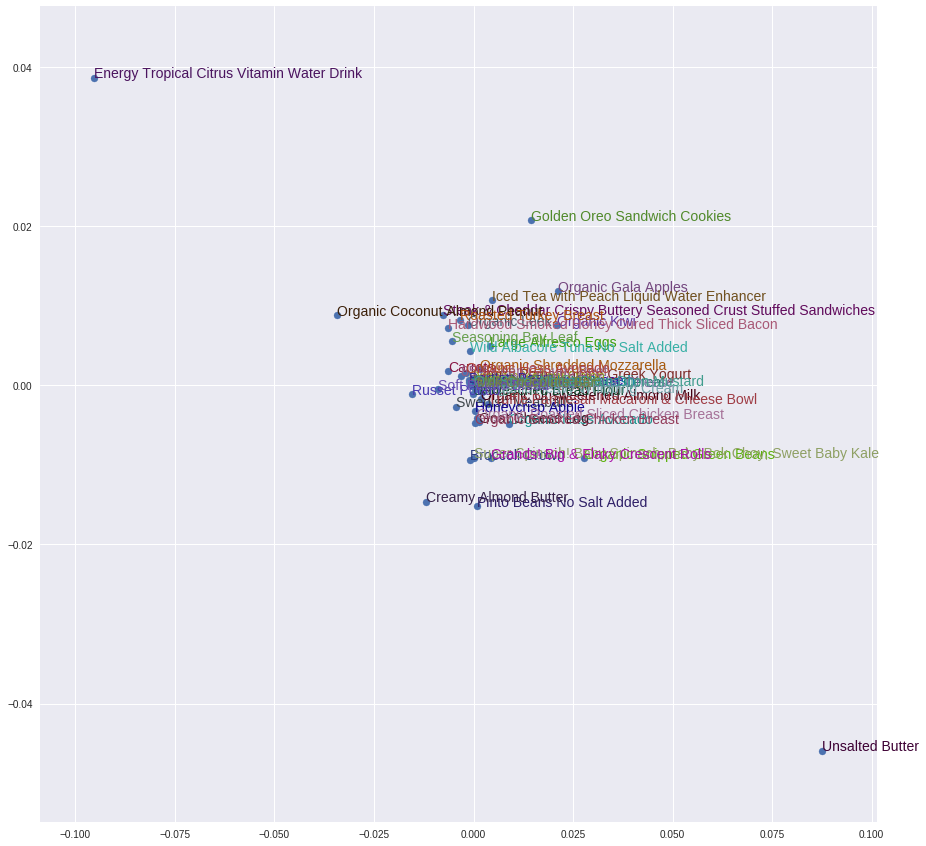

In [106]:
start=50; end=100
X = fac0[start:end]
Y = fac2[start:end]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topProds[start:end], X, Y):
    plt.text(x,y,prod_names()[prods[i]], color=np.random.rand(3)*0.7, fontsize=14)
plt.show()